In [1]:
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import numpy as np
import time, datetime

In [2]:
FILE_PATH = "/Users/apple/spark/data/project/A-sets/a1.txt"

MIN_PTS = 4
EPSILON = 900
X_UNIT, Y_UNIT = 5000, 5000
SPAN_MARGIN = EPSILON/2 + 1
NOISE_LABEL = -2
DATA_NUM = 50

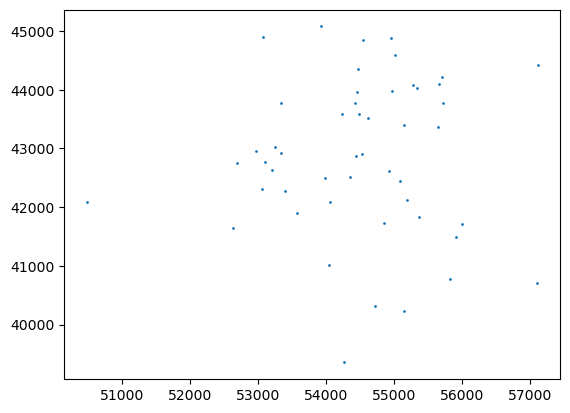

In [3]:
# read and organize the data as RDD
def parse_line(line):
    return [int(x) for x in line.strip().split()]

dataset = sc.textFile(FILE_PATH)\
    .map(parse_line)\
    .zipWithIndex().map(lambda x: (x[1], x[0])).repartition(2)\
    .filter(lambda x: x[0] < DATA_NUM) # only keep the first DATA_NUM points    
    
plt.scatter(dataset.map(lambda x: x[1][0]).collect(), dataset.map(lambda x: x[1][1]).collect(), s=1)

In [11]:
dataset.filter(lambda x: x[0] == 46).collect()

[(46, [50478, 42084])]

In [12]:
start_time = time.time()

x_min, x_max = dataset.map(lambda x: x[1][0]).min(), dataset.map(lambda x: x[1][0]).max()
y_min, y_max = dataset.map(lambda x: x[1][1]).min(), dataset.map(lambda x: x[1][1]).max()
print(x_min, x_max, y_min, y_max, '\nlength:', x_max-x_min, y_max-y_min)

x_grid = list(range(x_min, x_max + X_UNIT, X_UNIT))
y_grid = list(range(y_min, y_max + Y_UNIT, Y_UNIT))

area_list = []
area_cnt = 0
for x_idx, x_start in enumerate(x_grid[:-1]):
    for y_idx, y_start in enumerate(y_grid[:-1]):
        x_start_adjusted = x_start - SPAN_MARGIN
        y_start_adjusted = y_start - SPAN_MARGIN
        x_end_adjusted = x_grid[x_idx+1] + SPAN_MARGIN
        y_end_adjusted = y_grid[y_idx+1] + SPAN_MARGIN
        area_list.append([area_cnt, x_start_adjusted, x_end_adjusted, y_start_adjusted, y_end_adjusted])
        area_cnt += 1
assert len(area_list) == (len(x_grid)-1)*(len(y_grid)-1)

print(f'after generating area_list, time used: {time.time()-start_time}')
# organize the area into an RDD
# area_list_rdd = sc.parallelize(area_list)
print(f'area_list_rdd.count(): {len(area_list)}')


50478 57115 39356 45077 
length: 6637 5721
after generating area_list, time used: 0.47390222549438477
area_list_rdd.count(): 4


In [13]:

# for each point, find the area it belongs to (a point can belong to multiple areas)
def find_area(point):
    global area_list
    x, y = point
    area_idx_list = []
    for area in area_list:
        if area[1] <= x <= area[2] and area[3] <= y <= area[4]:
            area_idx_list.append(area[0])
    return area_idx_list

data_id_cluster_id_list = dataset.map(lambda x: (x[0], find_area(x[1]), x[1]))
# format: (data_id, [area_id1, area_id2, ...], (x, y))

# key: area_id
# value: [(point_id, (x, y)), (point_id, (x,y)), ...])
area_id_point_id_list = data_id_cluster_id_list.flatMap(
    lambda x: [(area_id, (x[0], x[2])) for area_id in x[1]])\
    .groupByKey().map(lambda x: (x[0], list(x[1])))

# convert the data in an area to a numpy array
# 3 columns: data_id, x, y
def convert_to_np_array(data_list):
    return np.array([[x[0], x[1][0], x[1][1]] for x in data_list])

area_id_np_array = area_id_point_id_list.mapValues(convert_to_np_array)
# key: area_id
# value: np.array, shape=(n, 3)

In [ ]:
# test
data_split = area_id_np_array.take(1)[0][1]
label_tmp = dbscan_inline(data_split, EPSILON, MIN_PTS)

tmp_noise = data_split[np.where(label_tmp == -2)[0]]
tmp_cluster = data_split[np.where(label_tmp != -2)[0]]

plt.scatter(tmp_noise[:, 1], tmp_noise[:, 2], s=5, c='r')
plt.scatter(tmp_cluster[:, 1], tmp_cluster[:, 2], s=1, c='b')

print(tmp_noise)

In [16]:

def dbscan_inline(data, eps, min_pts):
    '''
    data: np.array, shape=(N, 2)
    eps: float
    min_pts: int
    
    Returns:
    labels: np.array, shape=(N,)
    '''
    def find_neighbors(data, point, eps):
        neighbors_id = []
        for i, p in enumerate(data):
            if np.linalg.norm(p - point) < eps:
                neighbors_id.append(i)
        return neighbors_id
    
    N = data.shape[0]
    labels = np.zeros(N, dtype=int) - 1 # -1: unclassified; -2: noise; 1, 2, 3, ...: cluster id
    c = 0
    for i in range(N):
        if labels[i] != -1:
            continue
        neighbors_id = find_neighbors(data, data[i], eps)
        if len(neighbors_id) < min_pts:
            labels[i] = -2
            continue
        c += 1
        labels[i] = c
        neighbors_id_prime = neighbors_id.copy()
        assert i in neighbors_id_prime
        neighbors_id_prime.remove(i)
        for j in neighbors_id_prime:
            if labels[j] == -2:
                labels[j] = c
            if labels[j] != -1:
                continue
            labels[j] = c
            neighbors_j = find_neighbors(data, data[j], eps)
            if len(neighbors_j) >= min_pts:
                neighbors_id_prime += neighbors_j
    return labels

# for each area, find the points in it and perform local DBSCAN
import sys
def local_dbscan(data, eps, min_pts):
    '''
    data: np.array, shape (n, 3)
    '''
    data_id = data[:, 0]
    data = data[:, 1:]
    # print('will call dbscan with data shape:', data.shape)
    label_pred = dbscan_inline(data, eps, min_pts)
    return list(zip(data_id, label_pred))

data_id_label_pred_list = area_id_np_array.mapValues(lambda x: local_dbscan(x, EPSILON, MIN_PTS))
# key: area_id
# value: [(data_id, local_label), (data_id, local_label), ...]

print('after local dbscan, time used:', time.time()-start_time)


after local dbscan, time used: 94.20331120491028


In [18]:
# test
data_id_label_pred_list.collect()

[(0,
  [(0, 1),
   (1, 1),
   (2, 1),
   (3, 1),
   (4, 1),
   (5, 1),
   (6, -2),
   (8, 1),
   (9, 1),
   (20, 1),
   (21, 1),
   (22, -2),
   (23, 1),
   (24, 1),
   (25, 1),
   (26, 1),
   (28, 1),
   (29, 1),
   (40, -2),
   (41, 1),
   (42, 1),
   (43, 1),
   (45, 1),
   (46, -2),
   (47, 1),
   (48, 1),
   (49, 1),
   (10, 1),
   (11, 1),
   (12, 1),
   (13, -2),
   (14, 1),
   (15, 1),
   (16, 1),
   (17, 1),
   (19, 1),
   (30, 1),
   (31, 1),
   (32, 1),
   (33, 1),
   (36, 1),
   (38, -2),
   (39, 1)]),
 (2,
  [(6, -2),
   (8, 1),
   (21, 1),
   (22, 2),
   (26, 2),
   (28, 1),
   (29, 2),
   (44, -2),
   (49, 2),
   (12, 1),
   (14, 1),
   (18, 2),
   (31, 2),
   (32, 1),
   (33, 1),
   (34, -2)]),
 (1,
  [(4, 1),
   (7, -2),
   (8, 1),
   (9, 1),
   (21, 1),
   (27, 1),
   (28, 1),
   (41, 1),
   (10, 1),
   (14, 1),
   (35, 1),
   (37, 1)]),
 (3, [(8, 1), (21, 1), (28, 1), (14, 1), (34, -2)])]

In [19]:

def transform_label(i: int, S: int, k, noise_label=-2) -> int:
    '''
    i: split id
    S: total number of splits
    k: the cluster id in split #i
    '''
    if k == noise_label:
        return noise_label
    else:
        return (k-1)*S + i


S = len(area_list)
print('S:', S)
data_id_corrected_label_pred_list = data_id_label_pred_list.map(lambda x: (x[0], [(y[0], transform_label(i=x[0], S=S, k=y[1])) for y in x[1]]))\
    .flatMap(lambda x: x[1])\
    .map(lambda x: (x[0], [x[1]]))\
    .reduceByKey(lambda x, y: x + y)
    # .cache()
    # .sortByKey().cache()
    # key = data_id, value = [label1, label2, ...]


S: 4


In [20]:
# test
data_id_corrected_label_pred_list.collect()

[(0, [0]),
 (2, [0]),
 (4, [0, 1]),
 (6, [-2, -2]),
 (8, [0, 2, 1, 3]),
 (20, [0]),
 (22, [-2, 6]),
 (24, [0]),
 (26, [0, 6]),
 (28, [0, 2, 1, 3]),
 (40, [-2]),
 (42, [0]),
 (46, [-2]),
 (48, [0]),
 (10, [0, 1]),
 (12, [0, 2]),
 (14, [0, 2, 1, 3]),
 (16, [0]),
 (30, [0]),
 (32, [0, 2]),
 (36, [0]),
 (38, [-2]),
 (44, [-2]),
 (18, [6]),
 (34, [-2, -2]),
 (1, [0]),
 (3, [0]),
 (5, [0]),
 (9, [0, 1]),
 (21, [0, 2, 1, 3]),
 (23, [0]),
 (25, [0]),
 (29, [0, 6]),
 (41, [0, 1]),
 (43, [0]),
 (45, [0]),
 (47, [0]),
 (49, [0, 6]),
 (11, [0]),
 (13, [-2]),
 (15, [0]),
 (17, [0]),
 (19, [0]),
 (31, [0, 6]),
 (33, [0, 2]),
 (39, [0]),
 (7, [-2]),
 (27, [1]),
 (35, [1]),
 (37, [1])]

In [21]:

set_list = data_id_corrected_label_pred_list.filter(lambda x: len(set(x[1])) > 1)
# key = data_id, value = [label1, label2, ...]


In [22]:
# test
set_list.collect()

[(4, [0, 1]),
 (8, [0, 2, 1, 3]),
 (22, [-2, 6]),
 (26, [0, 6]),
 (28, [0, 2, 1, 3]),
 (10, [0, 1]),
 (12, [0, 2]),
 (14, [0, 2, 1, 3]),
 (32, [0, 2]),
 (9, [0, 1]),
 (21, [0, 2, 1, 3]),
 (29, [0, 6]),
 (41, [0, 1]),
 (49, [0, 6]),
 (31, [0, 6]),
 (33, [0, 2])]

In [23]:

data_id_temp_label = data_id_corrected_label_pred_list.mapValues(lambda x: sorted(x)[-1])



In [24]:
# test
data_id_temp_label.filter(lambda x: x[1] == -2).collect()

data_id_temp_label.collect()

[(0, 0),
 (2, 0),
 (4, 1),
 (6, -2),
 (8, 3),
 (20, 0),
 (22, 6),
 (24, 0),
 (26, 6),
 (28, 3),
 (40, -2),
 (42, 0),
 (46, -2),
 (48, 0),
 (10, 1),
 (12, 2),
 (14, 3),
 (16, 0),
 (30, 0),
 (32, 2),
 (36, 0),
 (38, -2),
 (44, -2),
 (18, 6),
 (34, -2),
 (1, 0),
 (3, 0),
 (5, 0),
 (9, 1),
 (21, 3),
 (23, 0),
 (25, 0),
 (29, 6),
 (41, 1),
 (43, 0),
 (45, 0),
 (47, 0),
 (49, 6),
 (11, 0),
 (13, -2),
 (15, 0),
 (17, 0),
 (19, 0),
 (31, 6),
 (33, 2),
 (39, 0),
 (7, -2),
 (27, 1),
 (35, 1),
 (37, 1)]

In [25]:

def remove_noise_label_from_list(label_list, noise_label=-2):
    return [x for x in label_list if x != noise_label]

# def merge_sets(list1, list2):
#     # 将两个列表合并为一个列表
#     combined = list1 + list2
#     # 使用类似上面改进的合并逻辑
#     result = []
#     while combined:
#         current = combined.pop(0)
#         merged = None
#         for i, exist in enumerate(result):
#             if exist.intersection(current):
#                 exist.update(current)
#                 merged = i
#                 break
#         if merged is None:
#             result.append(current)
#         else:
#             new_merged = result.pop(merged)
#             combined.append(new_merged)
#     return result

def merge_intersecting_sets(set_list):
        merged_sets = []
        while set_list:
            current_set = set_list.pop(0)  # 从list中取出一个集合
            merged = None
            # 查找第一个与current_set有交集的集合
            for i, merged_set in enumerate(merged_sets):
                if merged_set & current_set:
                    merged_set.update(current_set)
                    merged = i
                    break
            if merged is None:  # 没有发现交集
                merged_sets.append(current_set)
            else:  # 发现交集，再次合并可能的交集
                new_merged_set = merged_sets.pop(merged)
                set_list.append(new_merged_set)  # 将更新后的集合重新加入检查
        return merged_sets

def merge_sets_new(list1, list2):
    # 将两个列表合并为一个列表
    combined = list1 + list2
    merged_sets = merge_intersecting_sets(combined)
    return merged_sets


merged_set_list = set_list.mapValues(remove_noise_label_from_list)\
    .mapValues(lambda x: [set(x)])\
    .values().treeReduce(lambda x, y: merge_sets_new(x, y))


In [26]:
merged_set_list

[{0, 1, 2, 3, 6}]

In [27]:

# merged_set_list = merge_intersecting_sets(real_set_list)
# # print('merged_set_list:', merged_set_list)
# # print('not_noise_data_cluster:', not_noise_data_cluster)

print('after merging intersecting sets, time used:', time.time()-start_time)

cluster_map = dict()
for merged_set in merged_set_list:
    if len(merged_set) < 2:
        continue
    merged_set = list(merged_set)
    for i in range(1, len(merged_set)):
        cluster_map[merged_set[i]] = merged_set[0]
        
print('cluster_map:', cluster_map)

# map and find the final cluster
def get_final_cluster(in_label):
    global cluster_map
    if cluster_map.get(in_label) is not None:
        return cluster_map[in_label]
    else:
        return in_label

data_id_final_cluster = data_id_temp_label.mapValues(get_final_cluster)

print('time used:', time.time()-start_time)

after merging intersecting sets, time used: 149.03797721862793
cluster_map: {1: 0, 2: 0, 3: 0, 6: 0}
time used: 149.03872418403625


In [28]:
# test
data_id_final_cluster.collect()

[(0, 0),
 (2, 0),
 (4, 0),
 (6, -2),
 (8, 0),
 (20, 0),
 (22, 0),
 (24, 0),
 (26, 0),
 (28, 0),
 (40, -2),
 (42, 0),
 (46, -2),
 (48, 0),
 (10, 0),
 (12, 0),
 (14, 0),
 (16, 0),
 (30, 0),
 (32, 0),
 (36, 0),
 (38, -2),
 (44, -2),
 (18, 0),
 (34, -2),
 (1, 0),
 (3, 0),
 (5, 0),
 (9, 0),
 (21, 0),
 (23, 0),
 (25, 0),
 (29, 0),
 (41, 0),
 (43, 0),
 (45, 0),
 (47, 0),
 (49, 0),
 (11, 0),
 (13, -2),
 (15, 0),
 (17, 0),
 (19, 0),
 (31, 0),
 (33, 0),
 (39, 0),
 (7, -2),
 (27, 0),
 (35, 0),
 (37, 0)]

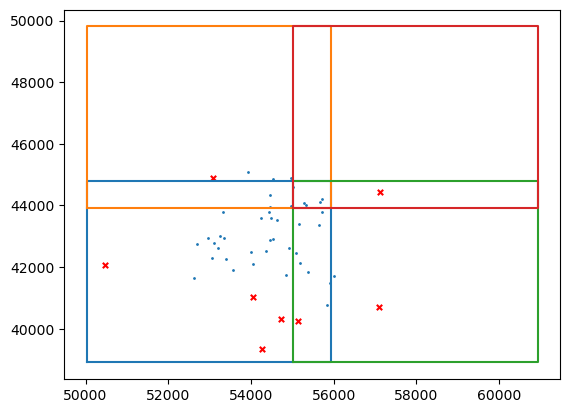

In [36]:

import sys
sys.path.append('..')
from utils import visualization
from importlib import reload
reload(visualization)
dataset_array = np.array(dataset.sortByKey().values().collect())#[data_id_final_cluster.keys().collect()]
visualization.visualize_dataset_with_label(dataset_array,
                                           label=np.array(data_id_final_cluster.sortByKey().values().collect()),
                                           split_list=area_list)